### Background:
Dataset of personal health tracking app including system/device information and personalized app attributes from each user and app installation.
### Purpose of this notebook:
- Exploratory data analysis
- Clean up raw data
- Add new features

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
file_path = '/Users/angiel/Documents/Data Sci/Food Diary app project/User EDA - Nov 2017/'

In [4]:
# read Excel file and save as pickle
df = pd.read_excel(file_path + 'App Stats 2018-03-16.xlsx', sheet_name='Sheet1')
df.to_pickle('df_2018-03-16')

In [3]:
df = pd.read_pickle(file_path + 'df_2018-03-16')

In [4]:
# conversion rate 0.34%, according to PM, this is average/good for this type of app
df[df['IsPaid']==True]['IsPaid'].count()/df['IsPaid'].count()

0.0034412003590817766

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888934 entries, 0 to 888933
Data columns (total 59 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ID                            888934 non-null  object        
 1   Class                         54464 non-null   object        
 2   InstallDate                   888934 non-null  datetime64[ns]
 3   LastSavedUTC                  888934 non-null  object        
 4   LastSync                      888934 non-null  object        
 5   Platform                      888934 non-null  object        
 6   FirstInstalledVersion         888817 non-null  object        
 7   DaysSinceInstall              888934 non-null  int64         
 8   SessionCount                  888934 non-null  int64         
 9   ExperimentID                  888934 non-null  int64         
 10  Experiment                    888934 non-null  object        
 11  MinLockedBott

<AxesSubplot:>

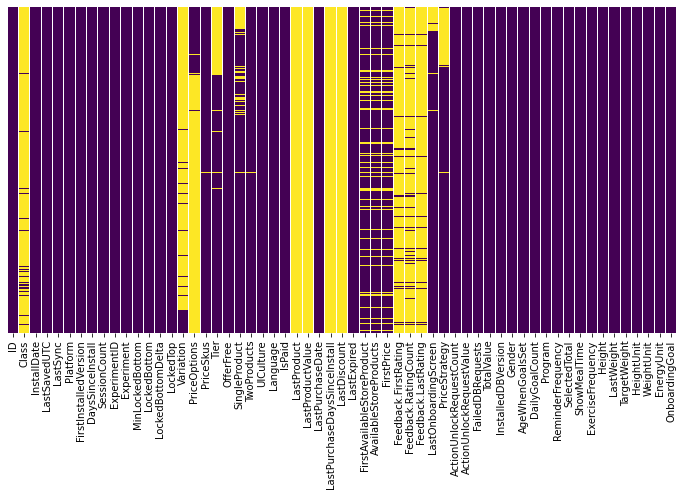

In [7]:
# Visual representation of where the missing data is. This graph does not include zero values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Exploratory data analysis
Which features might be used in a pricing model and/or predicting user conversion? Looking for any signals in the data.

## Device features:

### Platform
- iOS users 6x more likely to purchase product (subscribe to app) compared to Android users

In [6]:
df_platform = pd.pivot_table(df, index='Platform', values='IsPaid', aggfunc=('count','sum','mean', 'std'))
df_platform['% conversion'] = df_platform['mean'].round(5)*100

In [7]:
df_platform[['count', 'sum', '% conversion']]

,count,sum,% conversion
Platform,,,
Android,865414,2635,0.304
iOS,23520,424,1.803


#### Two proportion Z test
Requirements:
- binary data (yes/no, in this case, paid/not paid)
- random sample of each of the population groups that are being compared

H0 (null hypothesis): no difference in proportions between the two populations (Android and iOS)

Ha (alternative hypothesis): there is a difference in paid/subscribed proportions between Android and iOS users

In other words, we are testing \\(H_o: p_A=p_i\\) vs \\(H_a: p_A \neq p_i\\)

\\(z= \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2})}}\\) where \\(\hat{p}=\frac{n_1 \hat{p}_1 + n_2 \hat{p}_2}{n_1 + n_2} \\)

In [20]:
df_platform

,count,mean,std,sum,% conversion
Platform,,,,,
Android,865414,0.003045,0.055096,2635,0.304
iOS,23520,0.018027,0.133053,424,1.803


In [30]:
n1 = df_platform.loc['Android','count']
n2 = df_platform.loc['iOS','count']
c1 = df_platform.loc['Android','sum']
c2 = df_platform.loc['iOS','sum']

In [31]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([c1, c2])
nobs = np.array([n1, n2])
stat, pval = proportions_ztest(count, nobs)

In [32]:
print(stat, pval)

-38.71431129262527 0.0


In [33]:
# Double check result using formula above
p1 = c1/n1
p2 = c2/n2
p=(n1*p1 + n2*p2)/(n1+n2)
z=(p1-p2)/(np.sqrt(p*(1-p)*((1/n1)+(1/n2))))

In [34]:
print(z, p)

-38.71431129262527 0.0034412003590817766


Result: Z value is so large (not on the Z-table). We reject the null hypothesis.

### Free offer product
- conversion rate for those who were offered 'free' product (trial w/ full access to app features) is 0.71% compared to 0.24% for those not offered trial

In [42]:
df_offer = pd.pivot_table(df, index='OfferFree', values='IsPaid', aggfunc=('count','sum','mean','std'))
df_offer['% conversion'] = (df_offer['mean'].round(decimals=4))*100
df_offer

,count,mean,std,sum,% conversion
OfferFree,,,,,
False,699277,0.002438,0.049318,1705,0.24
True,189657,0.007139,0.084192,1354,0.71


#### Two proportion Z test

In [38]:
noff1 = 699277
noff2 = 189657
coff1 = 1705
coff2 = 1354

In [40]:
count_off = np.array([coff1, coff2])
nobs_off = np.array([noff1, noff2])
stat_off, pval_off = proportions_ztest(count_off, nobs_off)

In [41]:
print(stat_off, pval_off)

-31.0066935788899 4.379345902251484e-211


### UICulture
 - different conversion (subscription) rates for countries likely arises from difference in average app spending and relative competition (availability of similar apps in each language)

In [46]:
# list of top 20 UICultures with the most users
top_20_UICultures = df['UICulture'].value_counts().head(20).index.tolist()

In [47]:
df_UICulture = pd.pivot_table(df[df['UICulture'].isin(top_20_UICultures)], index='UICulture', values='IsPaid', aggfunc=('count','mean','std','sum'))

In [50]:
df_UICulture = df_UICulture.reindex(df_UICulture['mean'].sort_values(ascending=False).index)

In [51]:
df_UICulture['% conversion'] = (df_UICulture['mean'].round(decimals=4))*100

In [54]:
df_UICulture = df_UICulture[['count', '% conversion']]
df_UICulture.columns = ['total installs', '% conversion']

In [56]:
df_UICulture.head(10)

,total installs,% conversion
UICulture,,
en-US,58092,0.72
en-GB,32155,0.68
de-DE,36585,0.66
nl-NL,11230,0.62
it-IT,34117,0.49
ro-RO,30537,0.47
hu-HU,23016,0.36
sk-SK,12256,0.33
fr-FR,36446,0.31


### Variation

In [343]:
pd.pivot_table(df, index='Variation', values='IsPaid', aggfunc=('count', 'mean'))

,count,mean
Variation,,
"1,1,Default",24943,0.013230
"1,2,Vary",16511,0.002544
"1,3,Is3",16838,0.002673
"1,4,Is4",16770,0.002624


### LockedBottom 

In [344]:
pd.pivot_table(df, index='LockedBottom', values='IsPaid', aggfunc=('count', 'mean'))

,count,mean
LockedBottom,,
0,7411,0.017137
1,45453,0.005346
2,259704,0.002907
3,416487,0.003124
4,156434,0.003957
5,3445,0.004064


### Session count
- even amongst paid users, large drop after 20 app sessions -- suggests app retention and/or user compliance issue

(0, 600)

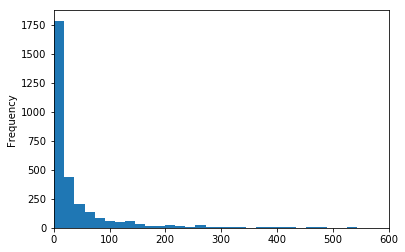

In [237]:
df[df['IsPaid']==True]['SessionCount'].plot.hist(bins=500)
plt.xlim(0,600)

### InstallDate
- number of installs jumped up at end of year/beginning of new year attributed to better download funnel (higher ratings, higher placing in search results) and seasonal differences (new year's resolutions)
- drop in conversion rate over time suggests difference between early and later users and maybe app competition
- data after 4-2018 is invalid, dataset only contains data up to 3-2018

In [233]:
Conversion_by_date = pd.pivot_table(df, index=[df['InstallDate'].dt.year, df['InstallDate'].dt.month],
                                    values='IsPaid', aggfunc=('count', 'mean'))

In [234]:
Conversion_by_date['mean'] = (Conversion_by_date['mean'].round(decimals=4))*100

In [235]:
Conversion_by_date.columns = ['total installs', 'conversion rate']

In [236]:
Conversion_by_date

total installs  conversion rate
InstallDate InstallDate                                 
1999        12                        1             0.00
2009        12                        4             0.00
2011        12                        1             0.00
2013        5                         1             0.00
            12                        1             0.00
2014        1                         1             0.00
            12                        8             0.00
2015        1                         3             0.00
            12                        6             0.00
2016        1                        10            10.00
            2                        13            38.46
            3                         7             0.00
            4                        21             0.00
            5                        18             0.00
            6                        37            21.62
            7                        27             7.41
            8                        45             8.89
            9                        52             9.62
            10                       79             7.59
            11                       64             4.69
            12                       93             2.15
2017        1                       278             3.24
            2                       306             4.25
            3                       465            13.98
            4                       498            13.45
            5                       617             3.73
            6                       843             5.81
            7                      1318             5.24
            8                      1791             3.91
            9                      2310             3.25
            10                    15131             0.90
            11                    79920             0.53
            12                    89589             0.46
2018        1                    271241             0.22
            2                    306093             0.25
            3                    118007             0.21
            4                        25             0.00
            5                         8             0.00
2026        11                        1             0.00
2037        5                         1             0.00

## App personalization features input by user:

### User age distribution

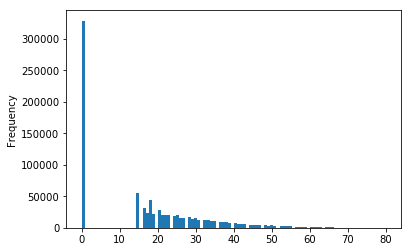

In [13]:
df['AgeWhenGoalsSet'].plot.hist(bins=100)

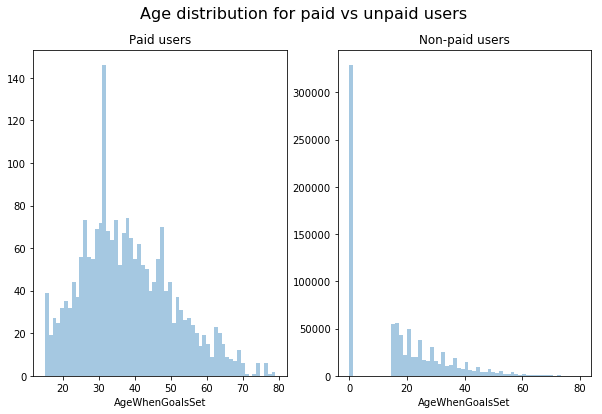

In [294]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.distplot(df[df['AgeWhenGoalsSet'].apply(lambda x: x>0) & df['IsPaid']==True]['AgeWhenGoalsSet'],
             kde=False, bins=60, ax=ax[0])
ax[0].set_title('Paid users')

sns.distplot(df[df['AgeWhenGoalsSet'].apply(lambda x: x>0) & df['IsPaid']==False]['AgeWhenGoalsSet'],
             kde=False, bins=60, ax=ax[1])
ax[1].set_title('Non-paid users')

plt.suptitle('Age distribution for paid vs unpaid users', fontsize=16)

In [96]:
rate = df[(df['AgeWhenGoalsSet']!=0) & (df['IsPaid']==True)]['AgeWhenGoalsSet'].count()/df['AgeWhenGoalsSet'].count()*100
print("Conversion rate, input age: %.2f%%" %rate)

rate = df[(df['AgeWhenGoalsSet']==0) & (df['IsPaid']==True)]['AgeWhenGoalsSet'].count()/df['AgeWhenGoalsSet'].count()*100
print("Conversion rate, DID NOT input age: %.2f%%" %rate)

Conversion rate, input age: 0.24%
Conversion rate, DID NOT input age: 0.10%


### Gender
- conversion rate (listed as mean) for males is 3x that of females or none (no response)

In [16]:
pd.pivot_table(df, index='Gender', values='IsPaid', aggfunc=('count','mean'))

,count,mean
Gender,,
Female,488048,0.003073
Male,72162,0.009091
None,328724,0.002747


### Program
- this feature does not provide a strong signal and is inherently very subjective

In [17]:
pd.pivot_table(df, index='Program', values='IsPaid', aggfunc=('count','mean'))

,count,mean
Program,,
Faster,144697,0.003552
LittleFaster,163928,0.003404
None,320945,0.002820
Normal,232778,0.004180
SlowAndSteady,26586,0.004100


### Onboarding goal
- most users want to lose/maintain/gain weight

In [341]:
pd.pivot_table(df, index='OnboardingGoal', values='IsPaid', aggfunc=('count','mean'))

,count,mean
OnboardingGoal,,
JustCurious,42354,0.002196
LoseMaintainOrGainWeight,528175,0.003970
None,167700,0.000185
NotOffered,9958,0.035047
Other,27520,0.006141
Skip,80233,0.001845
TrackSpecificNutritionGoals,32994,0.005213


### ReminderFrequency

In [18]:
pd.pivot_table(df, index='ReminderFrequency', values='IsPaid', aggfunc=('count','mean'))

,count,mean
ReminderFrequency,,
Disabled,87967,0.003240
ForEveryMeal,466857,0.003438
None,148697,0.003275
OncePerDay,185413,0.003678


### ShowMealTime
- whether or not this feature is chosen is a signal

In [19]:
pd.pivot_table(df, index='ShowMealTime', values='IsPaid', aggfunc=('count','mean'))

,count,mean
ShowMealTime,,
False,867095,0.002969
True,21839,0.022208


### TargetWeight
- whether or not target weight is inputted is a signal
- correlation with age
- target weight > 200 kg looks suspicious- software bug?
- minimum age required for downloading app is officially 15 years old

In [304]:
pivot_by_weight = pd.pivot_table(df, index=df['TargetWeight'].apply(lambda x: x!=0),
              values='IsPaid', aggfunc=('count', 'mean'))

pivot_by_weight

,count,mean
TargetWeight,,
False,312111,0.002871
True,576823,0.003750


In [310]:
rate1 = pivot_by_weight.iloc[1,1]*100
print("Conversion rate, input TargetWeight: %.2f%%" %rate1)
rate2 = pivot_by_weight.iloc[0,1]*100
print("Conversion rate, DID NOT input TargetWeight: %.2f%%" %rate2)

Conversion rate, input TargetWeight: 0.37%
Conversion rate, DID NOT input TargetWeight: 0.29%


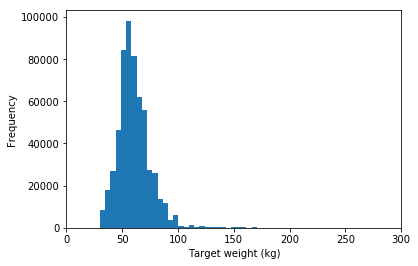

In [103]:
plt.figure()
df[df['TargetWeight']>0]['TargetWeight'].plot.hist(bins=100)
plt.xlim(0,300)
plt.xlabel('Target weight (kg)')

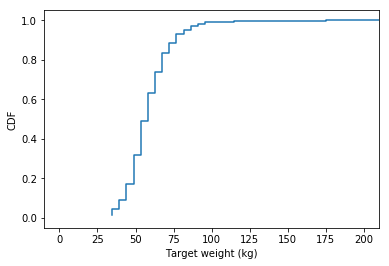

In [104]:
# cumulative distribution plot
df_tw = df[df['TargetWeight']>0]['TargetWeight']
#unique_elements, counts_elements = np.unique(df_tw.values, return_counts=True)

num_bins=100
counts, bin_edges = np.histogram(df_tw.values, bins=num_bins)
cdf = np.cumsum(counts/df_tw.count())

plt.step(bin_edges[1:], cdf)
plt.xlim(-10,210)
plt.ylim(-0.05,1.05)
plt.xlabel('Target weight (kg)')
plt.ylabel('CDF')

In [50]:
df[df['TargetWeight']>0]['TargetWeight'].describe()

count    576823.00000
mean         60.54361
std          17.02299
min          30.00200
25%          50.00000
50%          59.00000
75%          68.00000
max         498.95220
Name: TargetWeight, dtype: float64

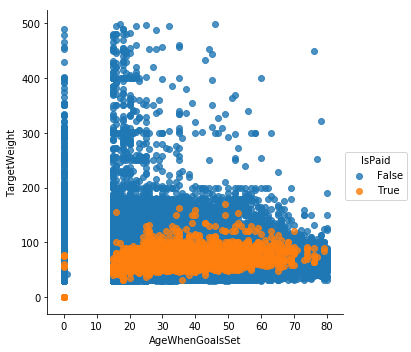

In [122]:
sns.lmplot(x='AgeWhenGoalsSet', y='TargetWeight', data=df, hue='IsPaid', fit_reg=False)

## Cleaning the data and adding new features

### DaysSinceInstall: all zeros, calculate # days since install including first day 

In [6]:
# DaysSinceInstall does not have values
df['DaysSinceInstall'].value_counts()

0    888934
Name: DaysSinceInstall, dtype: int64

In [7]:
from datetime import datetime
from datetime import timedelta

In [8]:
# include the day it was installed
df['DaysSinceInstall'] = datetime(2018,3,16) - df['InstallDate'] + timedelta(days=1)

In [9]:
# change to integer type
df['DaysSinceInstall']=(df['DaysSinceInstall'] / np.timedelta64(1, 'D')).astype(int)

In [10]:
# something wrong with InstallDate, has many dates in the future
df[df['DaysSinceInstall']<=0]['DaysSinceInstall'].count()

79

In [11]:
# No paid entries with negative DaysSinceInstall
df[(df['DaysSinceInstall']<=0) & (df['IsPaid']==True)]['ID'].count()

0

In [12]:
# Reset the entries with negative DaysSinceInstall to 1 day
df.loc[df['DaysSinceInstall']<=0, 'DaysSinceInstall']=1

In [13]:
df[df['DaysSinceInstall']<=0]['DaysSinceInstall'].count()

0

## Add new features
- create features that allow for comparison
- create features that indicate whether or not user input any data (Age, TargetWeight)

### AgeInput: whether or not user input any data

In [14]:
df['AgeInput']=df['AgeWhenGoalsSet']/df['AgeWhenGoalsSet']

In [15]:
df['AgeInput'].fillna(value=0, inplace=True)

In [16]:
df['AgeInput'] = df['AgeInput'].astype(bool)

In [17]:
df['AgeInput'].value_counts()

True     560211
False    328723
Name: AgeInput, dtype: int64

### TargetWeightInput: whether or not user input any data

In [18]:
df['TargetWeightInput'] = df['TargetWeight']/df['TargetWeight']

In [19]:
df['TargetWeightInput'].fillna(value=0, inplace=True)
df['TargetWeightInput'] = df['TargetWeightInput'].astype(bool)

In [20]:
df['TargetWeightInput'].value_counts()

True     576823
False    312111
Name: TargetWeightInput, dtype: int64

### SessionsPerDay
- for paid users, appears as if most have stopped using the app (assuming active user would access app 1-5x per day)
- possible issue with recording sessions in app data
- need to define what constitues an active user

In [21]:
# SessionsPerDay
df['SessionsPerDay'] = df['SessionCount']/df['DaysSinceInstall']

(0, 5)

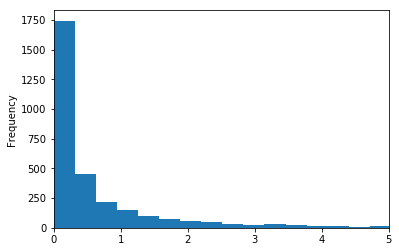

In [22]:
df[df['IsPaid']==True]['SessionsPerDay'].plot.hist(bins=100)
plt.xlim(0,5)

### WeightDiff
- user's goal (weight loss or gain)

In [23]:
df['WeightDiff'] = df['TargetWeight'] - df['LastWeight']

### LastBMI and TargetBMI
- combine height and weight into one variable
- indicator of "health" or "fitness"

In [24]:
# current BMI (kg/m^2) = last weight (kg)/height^2 (m^2)
df['LastBMI'] = df['LastWeight']/((df['Height']/100)**2)

# target BMI (kg/m^2) = target weight(kg)/height^2 (m^2)
df['TargetBMI'] = df['TargetWeight']/((df['Height']/100)**2)

### AgeGroup: add new feature for age groups based on distribution
- address sparse data issue with few paid users for a given age year
- as anticipated, older users are willing to and/or have the means to pay compared to younger users

In [25]:
# split dataframe into two: 1) zero value of AgeWhenGoalsSet and 2) non-zero values of AgeWhenGoalsSet
df_age_zero = df[df['AgeWhenGoalsSet']==0]
df_age_nonzero = df[df['AgeWhenGoalsSet']!=0]

# bin age into quintiles and assign to column AgeGroup
quintiles = pd.qcut(df_age_nonzero['AgeWhenGoalsSet'], 5, labels=[1,2,3,4,5])
df_age_nonzero = df_age_nonzero.assign(AgeGroup=quintiles.values)

# change from category to int
df_age_nonzero['AgeGroup'] = df_age_nonzero['AgeGroup'].astype(int)

# set AgeGroup=0 for zero age (no input)
df_age_zero = df_age_zero.assign(AgeGroup=0)

# recombine dataframes
df = pd.concat([df_age_zero,df_age_nonzero])

In [26]:
pd.pivot_table(df, index='AgeGroup', values='IsPaid', aggfunc=('count','mean'))

,count,mean
AgeGroup,,
0,328723,0.002747
1,154096,0.000552
2,71676,0.001284
3,110993,0.002685
4,115949,0.005166
5,107497,0.010065


### LastProduct, LastProductValue, SingleProduct, TwoProducts
- change nan values to 'not paid' or zero

In [27]:
df['LastProduct'].fillna(value='not_paid', inplace=True)
df['LastProductValue'].fillna(value=0, inplace=True)
df['SingleProduct'].fillna(value='not_offered', inplace=True)
df['TwoProducts'].fillna(value='not_offered', inplace=True)

### Save cleaned data and new features

In [ ]:
df.to_pickle('df_clean-2018-03-16-newfeat')

### QProductAmtOffer: add new feature to show dollar amount offered for a Q subscription product

In [29]:
df_clean = pd.read_pickle('df_clean-2018-03-16-newfeat')

In [30]:
# save subset of dataframe with Q product as separate
df_Q = pd.DataFrame(df_clean.loc[df['SingleProduct'].str.contains('q'), df_clean.columns])

In [31]:
df_Q = df_Q.reset_index(drop=True)

In [32]:
df_Q['SingleProduct'].value_counts()

q4       141550
q10      122898
q6        67941
q8        55785
q12       45734
q3        16222
q2        12717
i_q10        30
i2_q6        22
i2_q8        20
Name: SingleProduct, dtype: int64

In [33]:
# The number following 'q' is the price offered.
df_Q['QProductAmtOffer']=df_Q['SingleProduct'].str.extract(r'(?<=q)(\d+)', expand=False).fillna(0).astype(int)

### QProductAmtPaid: amount paid for a Q product subscription offer

In [ ]:
# If user pays, LastProduct records the subscription. 
# Find all subscriptions with 'q' and strip the number following it.

In [34]:
df_Q['QProductAmtPaid']=df_Q['LastProduct'].str.extract(r'(?<=q)(\d+)', expand=False).fillna(0).astype(int)

In [35]:
df_Q['QProductAmtPaid'].value_counts()

0     461779
4        407
10       318
6        149
12       106
8         64
3         54
2         42
Name: QProductAmtPaid, dtype: int64

### Save cleaned data

In [36]:
df_Q.to_pickle('df_clean-2018-03-16-reducedQ')